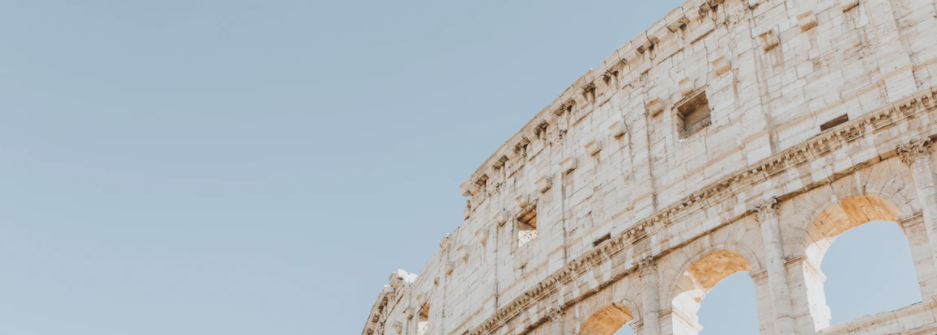

Photo by Braden Collum on [Unsplash](http://unsplash.com/photos/75XHJzEIeUc). 

# Extracting Air Quality Insights w/ Data Visualization 🍃

 > ### 📌 Short Summary 
In this notebook, you'll find:  

     * About the dataset
     * Exploratory Data Analysis
     * Data Visualization

This dataset is from the UCI machine learning repository and contains hourly averaged responses from an air quality multi-sensor device that was located in a significantly polluted area at road level in an undisclosed Italian city. This data was collected over the course of approx one year (from March 2004 - February 2005)

Dataset attribute information:

* 0 Date (DD/MM/YYYY)
* 1 Time (HH.MM.SS)
* 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
* 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
* 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
* 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
* 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
* 7 True hourly averaged NOx concentration in ppb (reference analyzer)
* 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
* 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
* 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
* 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
* 12 Temperature in Â°C
* 13 Relative Humidity (%)
* 14 AH Absolute Humidity

Also something to note: all missing values have been tagged with -200 values. To add more context to the attributes, I made an article detailing each one and some assumptions I drew up and trends that I've forecasted based on the attributes. You can find it [here](http://tenzin-migmarr.medium.com/extracting-air-quality-insights-with-data-exploration-and-visualization-72751b1f64d0). 

In [ ]:
# importing dependencies

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

df = pd.read_csv("../input/datasetucimlairquality/AirQualityUCI.csv", parse_dates={'datetime': ['Date', 'Time']})

df.head()

In [ ]:
# data exploration 

df.info(), df.shape     

In [ ]:
# more data exploration

df.describe(), df['CO_level'].value_counts()

In [ ]:
# normally, using isna().sum() would be enough to find missing vals but for this dataset, missing values have been tagged as -200. 
# we'll have to go through each column to find -200 values and then pass judgement as to dropping rows or entire columns. 

columns = {"Date", "Time", "CO_GT", "PT08_S1_CO", "NMHC_GT", "C6H6_GT", "PT08_S2_NMHC", "Nox_GT", "PT08_S3_Nox", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T", "RH", "AH", "CO_level"}

def findNumOfMissingVals(col):
    allValues = []
    
    for column in col:
        val = 0 
        for i in df[column]:
            if i == -200:
                val += 1
        allValues.append(val)
                         
    return allValues

values = findNumOfMissingVals(['AH','C6H6_GT','CO_GT','CO_level','datetime','NMHC_GT','NO2_GT','Nox_GT','PT08_S1_CO','PT08_S2_NMHC','PT08_S3_Nox','PT08_S4_NO2','PT08_S5_O3','RH','T'])
valuesMapped = dict(zip(sorted(columns), values))

valuesMapped

In [ ]:
# a lot of the columns have > 300 missing values which is quite the issue. 3 columns have > 1600 missing values. 
# one column (NMHC_GT) has 8443 missing values out of 9357 total values so that column will have to be dropped.
df.drop('NMHC_GT', axis=1, inplace=True)

# the rest of the columns will not be dropped but I'll have to drop every row that has 1 or more missing values. Hopefully, this will not result in too many dropped. 
# i'm currently staking this strategy on the assumption (since many cols have the exact same # of missing values) that these missing values are in the same row. 

# Replace -200 with null values.
def replaceValues(value1, value2, df):
    df = df.replace(value1, value2)
    return df

df2 = df.copy()

df2 = replaceValues(-200, np.nan, df2)

# go through rows and drop rows w/ 1 or more NaN values. 
def dropMissingRows(df):
    df = df.dropna(axis=0)
    return df
    
df2 = dropMissingRows(df2)

df2 = df2.sort_values(by=['datetime'], ascending=True)

# checking new data 
df2.head()

In [ ]:
# more rows were dropped than I would've liked but 6941 is still a good amount of values. 
df2.shape

In [ ]:
# more data exploration through visualizing

def showDistributions(category1, category2, category3):
    fig, axes = plt.subplots(1,3, figsize=(25, 5))
    sns.histplot(data=df2, x=category1, kde=True, color="darkseagreen", ax=axes[0])
    axes[0].set_title("Distribution of {}".format(category1))
    sns.histplot(data=df2, x=category2, kde=True, color="darkseagreen", ax=axes[1])
    axes[1].set_title("Distribution of {}".format(category2))
    sns.histplot(data=df2, x=category3, kde=True, color="darkseagreen", ax=axes[2])
    axes[2].set_title("Distribution of {}".format(category3))

showDistributions("PT08_S1_CO", "PT08_S2_NMHC", "Nox_GT")
showDistributions("CO_GT", "C6H6_GT", "PT08_S3_Nox")
showDistributions("NO2_GT", "PT08_S4_NO2", "PT08_S5_O3")

In [ ]:
# data visualization functions

def visualizeScatter(df, x, y, fill, title):
    fig = px.scatter(df, 
    x=x, 
    y=y, 
    color=fill, 
    #     facet_row=fill, 
    title=title)
    
    fig.show()

def visualizeFilledArea(x, y, fill, hd):
    fig = px.area(df, 
    x=x, 
    y=y,
    color=fill,
    hover_data=[hd])
  
    fig.show()

def visualizeLineCharts(df, columns, x1, title):   
    columns = columns 
    
    fig = go.Figure([{
    'x': df[x1],
    'y': df[col],
    'name': col
    }  for col in columns], layout=go.Layout(title=go.layout.Title(text=title)))
    
    fig.show()

def showViolinPlot(x, y, x2, y2, x3, y3):
    fig, axes = plt.subplots(1,3, figsize=(25, 5))
    sns.violinplot(x=x, y=y, data=df2, hue=x, palette='rocket', ax=axes[0])
    axes[0].set_title("{} by {}".format(x, y))

    
    sns.violinplot(x=x2, y=y2, data=df2, hue=x2, palette='rocket', ax=axes[1])
    axes[1].set_title("{} by {}".format(x2, y2))

    
    sns.violinplot(x=x3, y=y3, data=df2, hue=x3, palette='rocket', ax=axes[2])
    axes[2].set_title("{} by {}".format(x3, y3))
    
def displayHeatMap(dim1, dim2, title, df):
    fig=plt.figure(figsize=(dim1,dim2))
    plt.title(title)
    sns.heatmap(df, annot= True, cmap='flare')

In [ ]:
# Correlations between attributes 

corr = df.corr()
displayHeatMap(12, 12, 'Correlation Between Air Quality Attributes', corr)

In [ ]:
# Air pollutants concentrations change over time span of 24 hours (2004-03-11)

twentyFourHrSpanDf = df2[6:28].copy()

visualizeLineCharts(twentyFourHrSpanDf, ['CO_GT', 'C6H6_GT', 'Nox_GT', 'NO2_GT'], 'datetime', "Air Pollutant Concentrations Change Over 2004-03-11")

In [ ]:
# hourly averaged air pollutants concentrations change over first day in dataset (2004-03-10)

firstDaydf = df2[:6].copy()
visualizeLineCharts(firstDaydf, ['CO_GT', 'C6H6_GT', 'Nox_GT', 'NO2_GT'], 'datetime', "Air Pollutant Concentrations Change Over 2004-03-10")

# hourly averaged NO2 concentration in microg/m^3 change over the near end of last day in dataset (2005-04-04) 
lastDaydf = df[9343: -8].copy() # <- When dropping the rows w/ -200 values tagged, it dropped more recent dates than I would've liked so new df creation dropping CO_GT column.
lastDaydf.drop('CO_GT', axis=1, inplace=True)

visualizeLineCharts(lastDaydf, ['C6H6_GT', 'Nox_GT', 'NO2_GT'], 'datetime', "Air Pollutant Concentrations change over 2005-03-13")

In [ ]:
# change over 1 entire week in june (2004-06-07) 

dfWeekday = df['datetime'].dt.day_name()
df['week_day'] = dfWeekday

days = ['Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',  
'Friday',  
 'Saturday', 
 'Sunday']

def createSub(lst, col):
    for i in df.index:
        test_days = list(df[col][i:i+7])
        if test_days == lst:
            week_df = df.iloc[i:i+7,:]
            break
    return week_df
        
week_df = createSub(days, 'week_day')
    
visualizeLineCharts(week_df, ['C6H6_GT', 'Nox_GT', 'NO2_GT'], 'datetime', "Air Pollutant Concentrations change over 1 week")

In [ ]:
# change in concentrations over temp, relative humidity, absolute humidity

visualizeScatter(df2, 'RH', 'T', 'RH', 'Concentrations over Temperature and Relative Humidity')

In [ ]:
visualizeScatter(df2, 'AH', 'T', 'AH', 'Concentrations over Temperature and Absolute Humidity')

In [ ]:
# Concentrations of CO_level  over the Year

visualizeScatter(df2, 'CO_level', 'datetime', 'CO_level', 'Concentrations of CO_level over the Year')

In [ ]:
# correlation between temp and CO_level

showViolinPlot('CO_level', 'T', 'CO_level', 'CO_GT', 'CO_level', 'RH')

In [ ]:
# first half of year time span of air quality concentrations

def createDataSubset(df, range1, range2):
    first = df[range1:range2]
    return first

visualizeScatter(createDataSubset(df2, 0, 3470), 'datetime', 'Nox_GT', 'Nox_GT', 'Nox_GT Concentrations over First half of year')

In [ ]:
# second half of year time span of air quality concentrations

visualizeScatter(createDataSubset(df2, 3470, 6941), 'datetime', 'Nox_GT', 'Nox_GT', 'Nox_GT Concentrations over second half of year')

In [ ]:
# full year time span of air quality concentrations (CO_GT, PT08_S1_CO, C6H6_GT)

visualizeLineCharts(df2, ["CO_GT", "PT08_S1_CO", "C6H6_GT"], 'datetime', "1 Year Time Span of Air Concentrations")

In [ ]:
# full year time span of air quality concentrations (Nox_GT, PT08_S3_Nox, NO2_GT)

visualizeLineCharts(df2, ["Nox_GT", "PT08_S3_Nox", "NO2_GT"], 'datetime', "1 Year Time Span of Air Concentrations")